In [1]:
!gdown 1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW

Downloading...
From (original): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
From (redirected): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW&confirm=t&uuid=c0bae822-685d-4565-a3bc-0c27762082b8
To: /content/train_data.csv
100% 635M/635M [00:05<00:00, 110MB/s]


In [2]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import numpy as np
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from datasets import Features, Value
from transformers import BitsAndBytesConfig
import gc
import torch
from torch.utils.data import DataLoader

In [7]:
features = Features({
    'reviewText': Value('string'),
    'overall': Value('int64')
})

# Load the dataset
dataset = load_dataset('csv', data_files='./train_data.csv', split='train', features=features)

# Convert the dataset to a pandas DataFrame for undersampling
df = dataset.to_pandas()

# Perform undersampling on the raw data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df.drop(columns=['overall']), df['overall'])
balanced_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['overall'])], axis=1)

# Convert the balanced DataFrame back to a Hugging Face Dataset
balanced_dataset = Dataset.from_pandas(balanced_df)

# Filter out long reviews after undersampling
def filter_long_reviews(example):
    return len(example['reviewText']) <= 1000

filtered_dataset = balanced_dataset.filter(filter_long_reviews)

# Split the filtered dataset into train and validation sets
train_test_split = filtered_dataset.train_test_split(test_size=0.1, seed=42)
dt = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test']
})

# Load the tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(examples['reviewText'], truncation=True, padding=True, max_length=512)

encoded_dataset = dt.map(preprocess_function, batched=True)

# Map labels to start from 0
encoded_dataset = encoded_dataset.map(lambda x: {'labels': x['overall'] - 1})

# Set the format for PyTorch
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Final dataset dictionary with undersampled and preprocessed data
sampled_dataset = DatasetDict({
    'train': encoded_dataset['train'],
    'validation': encoded_dataset['validation']
})


Filter:   0%|          | 0/283780 [00:00<?, ? examples/s]

Map:   0%|          | 0/217316 [00:00<?, ? examples/s]

Map:   0%|          | 0/24147 [00:00<?, ? examples/s]

Map:   0%|          | 0/217316 [00:00<?, ? examples/s]

Map:   0%|          | 0/24147 [00:00<?, ? examples/s]

In [8]:
del dataset, df, X_resampled, y_resampled, balanced_df, balanced_dataset, filtered_dataset, train_test_split, dt, encoded_dataset
gc.collect()
torch.cuda.empty_cache()

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=5,
    ignore_mismatched_sizes=True,
)


training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    report_to="tensorboard",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    label_names=["labels"],
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    macro_f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')

    return {
        "accuracy": accuracy["accuracy"],
        "macro_f1": macro_f1["f1"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=sampled_dataset['train'],
    eval_dataset=sampled_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

model.save_pretrained("./fine_tuned_model")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-57d7b1403fb5>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Macro F1
1000,0.952200,0.966133,0.590094,0.577609
2000,0.895500,0.864147,0.621941,0.618938
3000,0.870700,0.848242,0.631010,0.631038
4000,0.768300,0.860861,0.638464,0.635539
5000,0.783300,0.834149,0.637098,0.630173
6000,0.774100,0.848957,0.637056,0.627031
7000,0.714300,0.926322,0.635110,0.635448
8000,0.652900,0.861924,0.643227,0.640414
9000,0.639700,0.883231,0.640245,0.640360
10000,0.648100,0.892017,0.643393,0.637015


Evaluation results: {'eval_loss': 1.211705207824707, 'eval_accuracy': 0.6421915765933657, 'eval_macro_f1': 0.641739346735848, 'eval_runtime': 54.1598, 'eval_samples_per_second': 445.847, 'eval_steps_per_second': 6.979, 'epoch': 5.0}


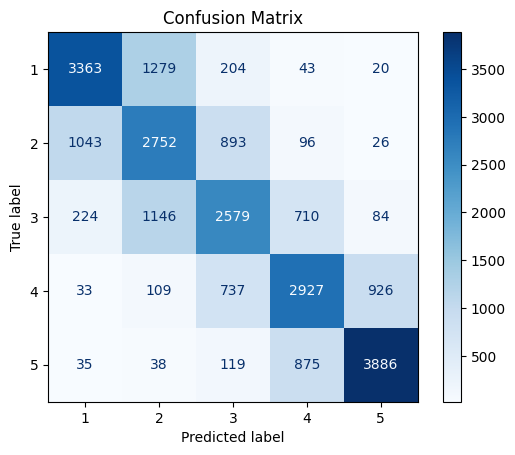

In [10]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

predictions = trainer.predict(sampled_dataset['validation'])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

| Class | Precision | Recall | F1-Score | Support |
| :-- | :-- | :-- | :-- | :-- |
| 1 | 0.72 | 0.69 | 0.70 | 4909 |
| 2 | 0.52 | 0.57 | 0.54 | 4810 |
| 3 | 0.57 | 0.54 | 0.56 | 4743 |
| 4 | 0.63 | 0.62 | 0.62 | 4732 |
| 5 | 0.79 | 0.78 | 0.79 | 4953 |
|  |  |  |  |  |
| Accuracy |  |  | 0.64 | 24147 |
| Macro avg | 0.64 | 0.64 | 0.64 | 24147 |
| Weighted avg | 0.64 | 0.64 | 0.64 | 24147 |
